# BYOL Analysis - Image and Embedding Loading

This notebook replicates the functionality of `byol_cluster_analysis_macos.py --mode analyze`.
It loads images and extracts embeddings using a trained BYOL model.

In [1]:
cd ../

/Users/kadofong/work/projects/merian/pieridae/scripts/byol


In [2]:
import os
import sys
import torch
import numpy as np
import yaml
from pathlib import Path
from tqdm import tqdm
import logging
import glob
import pickle
import pandas as pd
from torchvision import models, transforms
from torch import nn
from byol_pytorch import BYOL

print("📦 Imports completed successfully")

📦 Imports completed successfully


## Device Setup

Configure device with MPS (Apple Silicon) support if available.

In [3]:
def setup_device():
    """Setup device with MPS support for Apple Silicon"""
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"✅ Using Apple Silicon GPU (MPS): {device}")
        # Set memory fraction to avoid OOM on limited GPU memory
        torch.mps.set_per_process_memory_fraction(0.8)
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ Using NVIDIA GPU: {device}")
    else:
        device = torch.device('cpu')
        print(f"Using CPU: {device}")
        # Optimize CPU performance
        torch.set_num_threads(os.cpu_count())
    
    return device

device = setup_device()

✅ Using Apple Silicon GPU (MPS): mps


## Configuration Loading

Load configuration from the YAML file.

In [4]:
def load_config(config_path: str):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load configuration
config_path = 'byol_config.yaml'
config = load_config(config_path)

# Convert paths to Path objects
config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded from: {config_path}")
print(f"📁 Input path: {config['data']['input_path']}")
print(f"📁 Output path: {config['data']['output_path']}")
print(f"🖼️  Image size: {config['model']['image_size']}")

📋 Configuration loaded from: byol_config.yaml
📁 Input path: ../../local_data/pieridae_output/starlet/msorabove_v0
📁 Output path: ../../local_data/byol_results
🖼️  Image size: 150


## Data Loading

Load images using the same pattern as the cluster analysis script.

In [5]:
def load_data(data_path: Path):
    """Load image data from pickle files (same as cluster script)"""
    print(f"🔍 Loading image data from: {data_path}")
    
    pattern = f"{data_path}/M*/*i_results.pkl"
    filenames = glob.glob(pattern)
    
    if not filenames:
        raise FileNotFoundError(f"No files found matching pattern: {pattern}")
    
    print(f"📸 Found {len(filenames)} image files")
    
    imgs = []
    img_names = []
    
    for fname in tqdm(filenames, desc="Loading images"):
        img = []
        for band in 'gi':
            current_filename = fname.replace('_i_', f'_{band}_')
            
            try:
                with open(current_filename, 'rb') as f:
                    xf = pickle.load(f)
                    img.append(xf['image'])
                    if band == 'i':
                        img.append(xf['hf_image'])
            except FileNotFoundError:
                print(f"⚠️  File not found: {current_filename}")
                continue
        
        if len(img) == 3:  # Only add if we have all bands
            imgs.append(np.array(img))
            img_names.append(Path(fname).parent.name)
    
    images = np.array(imgs)
    img_names = np.array(img_names)
    
    print(f"✅ Loaded {len(images)} images with shape: {images.shape}")
    return images, img_names

# Load images
images, img_names = load_data(config['data']['input_path'])

🔍 Loading image data from: ../../local_data/pieridae_output/starlet/msorabove_v0
📸 Found 22913 image files


Loading images: 100%|████████████████████| 22913/22913 [00:43<00:00, 526.41it/s]


✅ Loaded 22913 images with shape: (22913, 3, 150, 150)


## BYOL Model Setup

Initialize the BYOL model with the same configuration used for training.

In [6]:
def setup_byol_model(config, device):
    """Setup BYOL model for inference"""
    print("🤖 Setting up BYOL model...")
    
    # Data augmentations (same as training)
    transform1 = nn.Sequential(
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    )
    
    transform2 = nn.Sequential(
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
    )
    
    # Base model - use ResNet18 for compatibility
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # BYOL learner
    learner = BYOL(
        resnet,
        image_size=config['model']['image_size'],
        hidden_layer='avgpool',
        projection_size=config['model']['projection_size'],
        projection_hidden_size=config['model']['projection_hidden_size'],
        moving_average_decay=config['model']['moving_average_decay'],
        use_momentum=True,
        augment_fn=transform1,
        augment_fn2=transform2
    ).to(device)
    
    print(f"✅ BYOL model setup complete on {device}")
    return learner

# Setup model
learner = setup_byol_model(config, device)

🤖 Setting up BYOL model...
✅ BYOL model setup complete on mps


## Load Trained Model Weights

Load the trained BYOL model from checkpoint.

In [7]:
def load_original_resnet_weights(learner):
    """Use original ResNet18 ImageNet weights (no BYOL training)"""
    print("📥 Using original ResNet18 ImageNet weights (no additional BYOL training)")
    print("✅ Model initialized with pretrained ImageNet weights")
    
    learner.eval()
    return learner

# Use original ResNet18 weights
learner = load_original_resnet_weights(learner)

📥 Using original ResNet18 ImageNet weights (no additional BYOL training)
✅ Model initialized with pretrained ImageNet weights


## Extract Embeddings

Extract embeddings from all loaded images using the trained BYOL model.

In [8]:
def extract_embeddings(learner, images, device, batch_size=128):
    """Extract embeddings from images using trained BYOL model"""
    print(f"🧠 Extracting embeddings from {len(images)} images...")
    
    learner.eval()
    all_embeddings = []
    
    # Adjust batch size for device capabilities
    if device.type == 'mps':
        batch_size = min(64, batch_size)  # Reduce for MPS
    
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Extracting embeddings"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            
            # Prepare batch
            batch = torch.tensor(
                images[start_idx:end_idx],
                dtype=torch.float32
            ).to(device)
            
            try:
                # Extract embeddings
                _, embeddings = learner(batch, return_embedding=True)
                all_embeddings.append(embeddings.cpu().numpy())
                
            except RuntimeError as e:
                if "MPS" in str(e) and device.type == 'mps':
                    print(f"⚠️  MPS error, falling back to CPU for batch {i}")
                    # Fallback to CPU for this batch
                    batch = batch.cpu()
                    learner_cpu = learner.cpu()
                    _, embeddings = learner_cpu(batch, return_embedding=True)
                    all_embeddings.append(embeddings.cpu().numpy())
                    # Move learner back to original device
                    learner = learner.to(device)
                else:
                    raise e
    
    # Combine all embeddings
    embeddings = np.vstack(all_embeddings)
    print(f"✅ Extracted embeddings shape: {embeddings.shape}")
    
    return embeddings

# Extract embeddings
embeddings = extract_embeddings(
    learner, 
    images, 
    device, 
    batch_size=config['inference']['batch_size']
)

🧠 Extracting embeddings from 22913 images...


Extracting embeddings: 100%|██████████████████| 359/359 [00:35<00:00, 10.11it/s]

✅ Extracted embeddings shape: (22913, 512)


## Dimensionality Reduction (PCA + UMAP)

Apply PCA and UMAP to the embeddings for visualization.

In [9]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def compute_pca_umap(embeddings, config):
    """Apply PCA and UMAP to embeddings"""
    print("🔄 Computing PCA and UMAP...")
    
    # Clean data
    embeddings_clean = np.nan_to_num(
        embeddings, nan=0.0, posinf=0.0, neginf=0.0
    )
    
    # Standardization
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_clean)
    
    # PCA
    pca_components = config['analysis']['pca_components']
    if pca_components is None:
        # Auto-determine based on variance threshold
        pca_full = PCA()
        pca_full.fit(embeddings_scaled)
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        threshold = config['analysis']['explained_variance_threshold']
        pca_components = np.argmax(cumsum_var >= threshold) + 1
    
    max_components = min(
        embeddings_scaled.shape[0] - 1,
        embeddings_scaled.shape[1]
    )
    pca_components = min(pca_components, max_components)
    
    pca = PCA(n_components=pca_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_scaled)
    
    # UMAP
    n_neighbors = min(
        config['analysis']['n_neighbors'],
        len(embeddings_pca) - 1
    )
    
    umap_reducer = umap.UMAP(
        n_components=config['analysis']['umap_components'],
        n_neighbors=n_neighbors,
        min_dist=config['analysis']['min_dist'],
        metric=config['analysis']['metric'],
        random_state=42,
        verbose=True
    )
    
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    
    print(f"✅ PCA components: {pca_components}")
    print(f"✅ UMAP embedding shape: {embeddings_umap.shape}")
    
    return {
        'scaler': scaler,
        'pca': pca,
        'umap': umap_reducer,
        'embeddings_original': embeddings_clean,
        'embeddings_pca': embeddings_pca,
        'embeddings_umap': embeddings_umap
    }

# Compute PCA and UMAP
reduction_results = compute_pca_umap(embeddings, config)

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


🔄 Computing PCA and UMAP...


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.01, n_jobs=1, random_state=42, verbose=True)
Wed Oct  8 10:14:31 2025 Construct fuzzy simplicial set
Wed Oct  8 10:14:31 2025 Finding Nearest Neighbors
Wed Oct  8 10:14:31 2025 Building RP forest with 13 trees
Wed Oct  8 10:14:35 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Wed Oct  8 10:14:41 2025 Finished Nearest Neighbor Search
Wed Oct  8 10:14:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct  8 10:14:55 2025 Finished embedding
✅ PCA components: 50
✅ UMAP embedding shape: (22913, 2)


## Load Classification Labels

Load the classification labels for creating the fraction maps.

In [10]:
def load_labels(config, img_names):
    """Load classification labels"""
    labels = None
    label_file = Path(config.get('labels', {}).get('classifications_file', './classifications_kadofong_20250929.csv'))
    
    if label_file.exists() and img_names is not None:
        try:
            mergers = pd.read_csv(label_file, index_col=0)
            labels = mergers.reindex(img_names)
            labels = labels.replace(np.nan, 0).values.flatten().astype(int)
            print(f"✅ Loaded classification labels: {len(labels)} objects")
            
            # Print label distribution
            unique, counts = np.unique(labels, return_counts=True)
            label_meanings = {
                0: "unclassified", 1: "undisturbed", 2: "ambiguous",
                3: "merger", 4: "fragmentation", 5: "artifact"
            }
            
            print("📊 Label distribution:")
            for label_val, count in zip(unique, counts):
                meaning = label_meanings.get(label_val, f"unknown_{label_val}")
                print(f"   {label_val} ({meaning}): {count} objects")
                
        except Exception as e:
            print(f"⚠️  Could not load labels: {e}")
            labels = None
    else:
        print(f"⚠️  Label file not found: {label_file}")
        labels = None
    
    return labels

# Load labels
labels = load_labels(config, img_names)

✅ Loaded classification labels: 22913 objects
📊 Label distribution:
   0 (unclassified): 20281 objects
   1 (undisturbed): 2004 objects
   2 (ambiguous): 207 objects
   3 (merger): 94 objects
   4 (fragmentation): 278 objects
   5 (artifact): 49 objects


# Use PCA to estimate labels

In [11]:
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from matplotlib import colors
from ekfplot import plot as ek
from scipy import ndimage

from sklearn.neighbors import NearestNeighbors

In [12]:
pca = reduction_results['pca']
print(f'Explained variance: {pca.explained_variance_ratio_.sum()*100:.1f} pct')

Explained variance: 84.9 pct


In [13]:
pca_embeddings = reduction_results['embeddings_pca']

nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(pca_embeddings)

distances, indices = nbrs.kneighbors(pca_embeddings)
distances[:,0] = np.nan

In [14]:
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 8)
print(f'Using minimum_labeled_neighbors = {n_min} from config')

Using minimum_labeled_neighbors = 8 from config


In [15]:
neighbor_labels = labels[indices]

weights = np.where( neighbor_labels>0, 1./distances, 0. )
weights /= np.nansum(weights,axis=1).reshape(-1,1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0),axis=1)
n_labels = np.sum(neighbor_labels>0,axis=1)


prob_labels[n_labels<n_min] = 0.
print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

4658 galaxies have auto-labels


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_68317/1701886768.py:4: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights,axis=1).reshape(-1,1)


In [16]:
# iterate over relatively certain labels
iterative_labels = labels.copy ()

n_labeled = (iterative_labels>0).sum()


additions = np.where(prob_labels[n_labels>=n_min] > 0.6)
new_labels = np.zeros_like(iterative_labels)
new_labels[additions[0]] = additions[1]

new_labels[(prob_labels[:,4]>0.1)&(n_labels>=n_min)] = 4


iterative_labels[iterative_labels==0] = new_labels[iterative_labels==0]
n_new = (iterative_labels>0).sum() - n_labeled
print(f'{(labels>0).sum()} human labels')
print(f'{n_new} auto-labels added, {(iterative_labels>0).sum()} labels total')

2632 human labels
4237 auto-labels added, 6869 labels total


In [17]:
neighbor_labels = iterative_labels[indices]

weights = np.where( neighbor_labels>0, 1./distances, 0. )
weights /= np.nansum(weights,axis=1).reshape(-1,1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0),axis=1)
n_labels = np.sum(neighbor_labels>0,axis=1)

prob_labels[n_labels<n_min] = 0.
print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

22030 galaxies have auto-labels


In [18]:
is_merger = ((prob_labels[:,2]+prob_labels[:,3])>prob_labels[:,1])&(prob_labels[:,4]<0.1)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_68317/2802391633.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','undisturbed','ambiguous','merger','fragmented'], rotation=35)


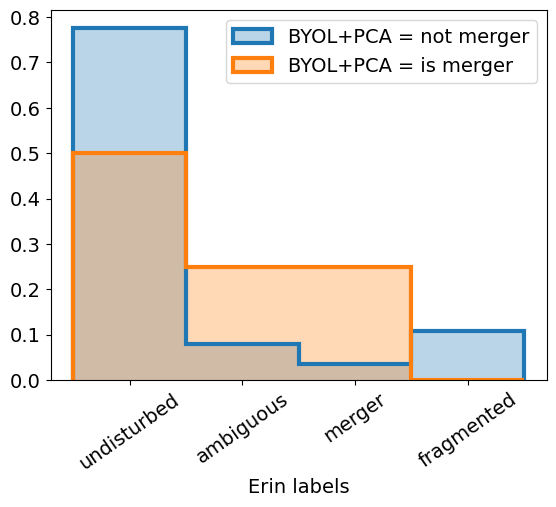

In [19]:
ax = plt.subplot(111)
ek.hist(labels[~is_merger], bins=np.arange(0.5,5), density=True, lw=3, alpha=0.3, label='BYOL+PCA = not merger')
ek.hist(labels[is_merger], bins=np.arange(.5,5), density=True, lw=3, alpha=0.3, label='BYOL+PCA = is merger')
ax.set_xticklabels(['','undisturbed','ambiguous','merger','fragmented'], rotation=35)
ax.set_xlabel('Erin labels')
plt.legend ()

IndexError: index 2 is out of bounds for axis 0 with size 2

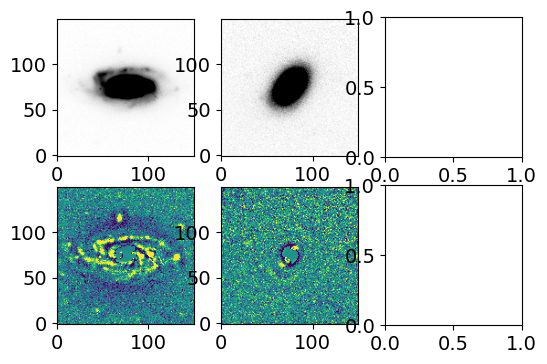

In [20]:
fig, axarr = plt.subplots(2,3,figsize=(6,4))

for aix,idx in enumerate(range(3)):
    ek.imshow(images[(labels==1)&is_merger][idx,1], ax=axarr[0,aix], q=0.05, cmap='Greys')
    ek.imshow(images[(labels==1)&is_merger][idx,2], ax=axarr[1,aix])

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout ()

<Axes: >

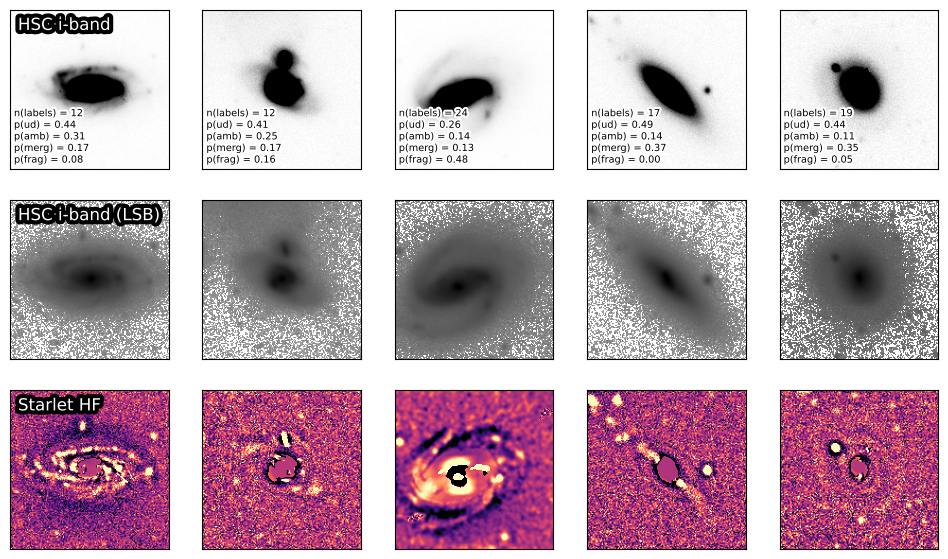

In [30]:
fig, axarr = plt.subplots(3, 5, figsize=(12,7))

fragmented = prob_labels[:,4] > 0.5
possible_merger = (prob_labels[:,2]+prob_labels[:,3]) > prob_labels[:,1]

candidates = np.arange(prob_labels.shape[0])[possible_merger&~fragmented][:]
for idx, gix in enumerate(candidates[:5]):
    ek.imshow(
        images[gix][1],
        ax=axarr[0, idx],
        q=0.05,
        cmap='Greys'
    )
    axarr[1,idx].imshow(
        ndimage.gaussian_filter(images[gix][1], 0),
        #ax=axarr[1, idx],
        origin='lower',
        cmap='Greys',
        norm=colors.LogNorm()
    )
    ek.imshow(
        images[gix][2],
        ax=axarr[2, idx],
        #q=0.05,
        cmap='magma'
    )
    ek.text(
        0.025,
        0.025,
        f'''n(labels) = {n_labels[gix]}
p(ud) = {prob_labels[gix,1]:.2f}
p(amb) = {prob_labels[gix,2]:.2f}
p(merg) = {prob_labels[gix,3]:.2f}
p(frag) = {prob_labels[gix,4]:.2f}''',
        ax=axarr[0,idx],
        fontsize=7, bordercolor='w', color='k', borderwidth=3
    )

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

ek.text(0.05,0.95, 'HSC i-band', ax=axarr[0,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'HSC i-band (LSB)', ax=axarr[1,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'Starlet HF', ax=axarr[2,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )

In [ ]:
del images


# Look at merger statistics

In [23]:
from ekfplot import colors as ec, plot as ek
from ekfphys import calibrations
from pieridae.starbursts import sample


In [24]:
base_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.7 seconds.
Computed internal extinction corrections in 0.8 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
fragmented = prob_labels[:,4] > 0.1
prob_merger = (prob_labels[:,2]+prob_labels[:,3])# > prob_labels[:,1]

In [26]:
catalog = base_catalog.reindex(img_names[~fragmented])
catalog['p_merger'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,3])
catalog['p_ambig'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,2])
catalog['p_undisturbed'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,1])

/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:494: RuntimeWarning: invalid value encountered in divide
  im=ax.pcolormesh(bins[0], bins[1], (weighted_counts/raw_counts).T, cmap=cmap, **kwargs)


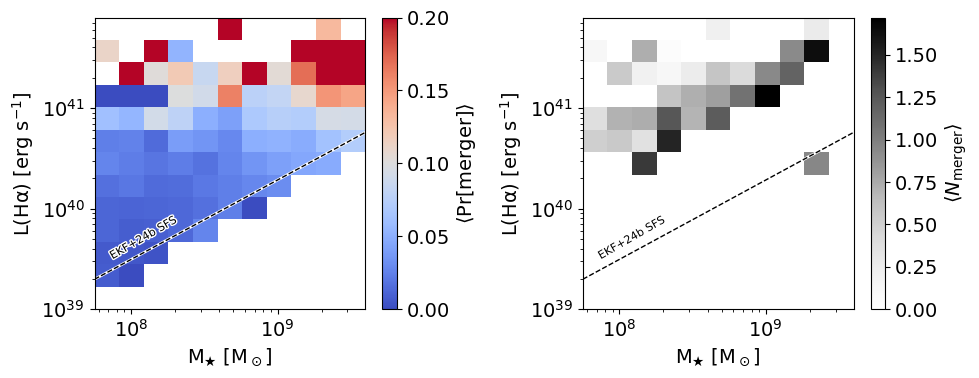

In [27]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))

bins = [np.logspace(7.75, 9.6,12), np.logspace(39,41.9,14)]
im,_=ek.pcolor_avg2d(
    10.**catalog['logmass'], 
    catalog['L_Ha'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    yscale='log',
    xscale='log',
    bins=bins,
    ax=axarr[0],
    vmax=0.2
    #s=3,
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

imx=ek.hist2d(
    10.**catalog['logmass'], 
    catalog['L_Ha'],
    weights=catalog['p_merger']+catalog['p_ambig'],
    cmap='Greys',
    yscale='log',
    xscale='log',
    bins=bins,
    ax=axarr[1]
    #s=3,
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

ms = im._coordinates.data[0,:,0]
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs = 10.**(alpha*(np.log10(ms) - 8.5) + norm)
ha_sfs = calibrations.SFR2LHa(sfs)
plt.colorbar(imx[0][-1],ax=axarr[1], label=r'$\langle N_{\rm merger} \rangle$')

plt.colorbar(im,ax=axarr[0], label=r'$\langle {\rm Pr[merger]}\rangle$')

for ax in axarr:
    ek.outlined_plot(
        ms,
        ha_sfs,
        ax=ax,
        lw=1,
        ls='--',
    )
    
    ek.text(
        7e7,
        3e39,
        'EKF+24b SFS',
        ax=ax,
        rotation=30,
        coord_type='absolute',
        va='bottom',
        ha='left',
        bordercolor='w',
        borderwidth=2,
        fontsize=8
    )    
    ax.set_xlabel(ek.common_labels['mstar'])
    ax.set_ylabel(ek.common_labels['halum'])
    ek.loglog(ax=ax)

#prob_merger = (catalog['p_merger']+catalog['p_ambig']) > catalog['p_undisturbed']
#axarr[0].scatter(
#    10.**catalog.loc[prob_merger, 'logmass'],
#    catalog.loc[prob_merger, 'L_Ha'],
#    color='lime'
#)
plt.tight_layout ()

In [ ]:
im,_=ek.pcolor_avg2d(
    catalog['logmass'], 
    catalog['z_spec'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    zscale='linear',
    bins=12
)

In [357]:
logmstar_bins = np.arange(7.75,10.,0.25)

In [358]:
groups = np.digitize(catalog['logmass'], logmstar_bins)

In [359]:
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs_at_mass = 10.**(alpha*(catalog['logmass'] - 8.5) + norm)
ha_sfs_at_mass = calibrations.SFR2LHa(sfs_at_mass)

In [400]:
np.where(pmerger>catalog['p_undisturbed'],1.,0.).sum()

22.0

<Axes: >

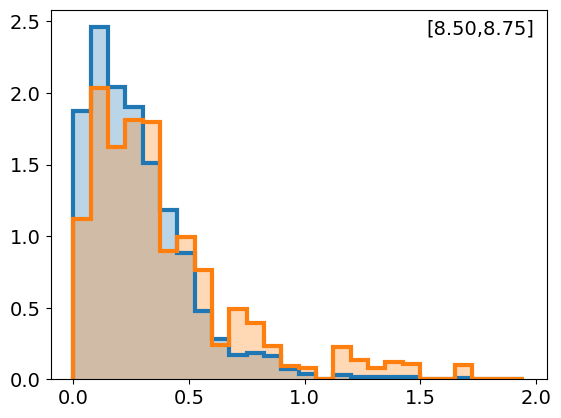

In [415]:
gid = 4

ms_at_mass = np.interp( 0.5*(logmstar_bins[gid-1]+logmstar_bins[gid]), np.log10(ms), np.log10(ha_sfs) )
hkwargs = {'alpha':.3,'lw':3, 'bins':np.arange(0, 42.-ms_at_mass, 0.075), 'density':True}

logmbounds = logmstar_bins[gid-1], logmstar_bins[gid]

pmerger = catalog['p_merger']+catalog['p_ambig']

ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, **hkwargs)
ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, 
         weights=pmerger.loc[groups==gid], **hkwargs)
#ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, 
#         weights=np.where(pmerger>0.25,1.,0.)[groups==gid], **hkwargs)
ek.text(0.975, 0.975, f'[{logmbounds[0]:.2f},{logmbounds[1]:.2f}]')


🎨 Creating classification fraction maps...


/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:494: RuntimeWarning: invalid value encountered in divide
  im=ax.pcolormesh(bins[0], bins[1], (weighted_counts/raw_counts).T, cmap=cmap, **kwargs)


💾 Classification fraction maps saved to: ../../local_data/byol_results/classification_fraction_maps.png


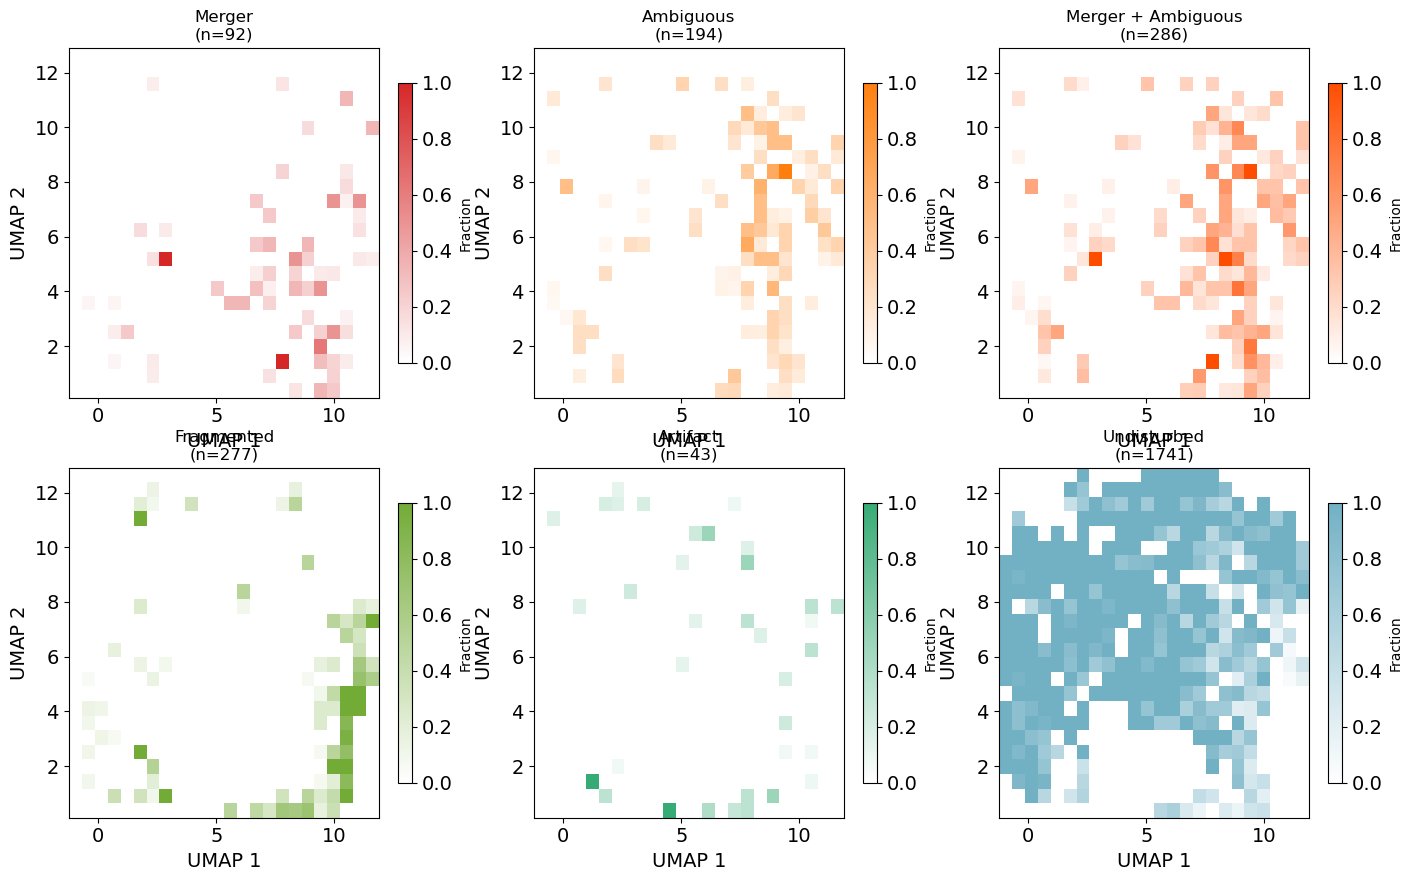

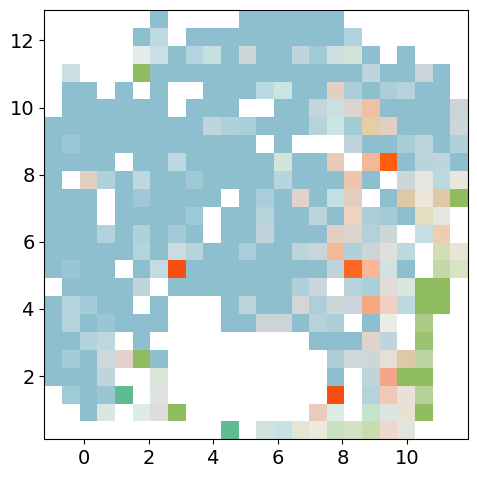

In [214]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ekfplot.plot as ek
import ekfplot.colors as ec
from ekfstats import sampling



def create_classification_fraction_maps(embeddings_umap, labels, output_path):
    """Create 6-panel classification fraction maps"""
    if labels is None:
        print("⚠️  No labels available for fraction maps")
        return
    
    print("🎨 Creating classification fraction maps...")
    
    # Define classifications and their meanings
    classifications = {
        3: "Merger",
        2: "Ambiguous", 
        'merger_ambiguous': "Merger + Ambiguous",
        4: "Fragmented",
        5: "Artifact",
        1: "Undisturbed"
    }
    color_d = {
        3: 'tab:red',
        2: 'tab:orange',
        'merger_ambiguous': '#ff4d00',
        4: '#73ab37',
        5: '#37ab75',
        1: '#72b0c4',
    }
    
    # Create figure with 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))
    fig2 = plt.figure(figsize=(5,5))
    ax2 = fig2.add_subplot(111)
    axes = axes.flatten()
    
    # Get UMAP coordinates
    has_label = labels > 0
    x = embeddings_umap[has_label, 0]
    y = embeddings_umap[has_label, 1]
    
    
    # Define grid parameters for binning
    nbins = 25
    imdict = {}
    for i, (class_key, class_name) in enumerate(classifications.items()):
        ax = axes[i]
        
        # Create binary mask for this classification
        if class_key == 'merger_ambiguous':
            # Combined merger + ambiguous
            mask = (labels == 3) | (labels == 2)
        else:
            # Single classification
            mask = (labels == class_key)
        
        # Convert boolean mask to 0/1 for fraction calculation
        z_values = mask[has_label].astype(float)
        

        try:
            im, axarr = ek.pcolor_avg2d(
                x, y, z_values,
                bins=nbins,
                ax=ax,
                cmap=ec.ColorBase(color_d[class_key]).sequential_cmap()
                #vmin=0, vmax=1,
            )
            _ = ek.pcolor_avg2d(
                x, y, z_values,
                bins=nbins,
                ax=ax2,
                cmap=ec.ColorBase(color_d[class_key]).translucify(0.8).sequential_cmap(fade=0.),
                #vmin=0, vmax=1,
            )            
        except Exception as e:
            print(f"⚠️  ekfplot error for {class_name}: {e}, using fallback")
            # Fallback to manual binning
            im = create_manual_fraction_map(x, y, z_values, ax, nbins)

        # Customize plot
        ax.set_title(f'{class_name}\n(n={np.sum(mask)})', fontsize=12)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        
        # Add colorbar
        if im is not None:
            cbar = plt.colorbar(im, ax=ax, shrink=0.8)
            cbar.set_label('Fraction', fontsize=10)

        imdict[class_key] = im
    
    plt.tight_layout()
    
    # Save plot
    output_path.mkdir(parents=True, exist_ok=True)
    plot_path = output_path / 'classification_fraction_maps.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"💾 Classification fraction maps saved to: {plot_path}")
    
    plt.show()
    return imdict

def create_manual_fraction_map(x, y, z_values, ax, nbins):
    """Manual implementation of 2D binned fraction map"""
    from scipy.stats import binned_statistic_2d
    
    # Create 2D histogram with mean values (fractions)
    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, z_values, 
        statistic='mean', 
        bins=nbins
    )
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    
    # Plot
    im = ax.pcolormesh(X, Y, stat.T, cmap='viridis', vmin=0, vmax=1)
    fig.tight_layout ()
    return im

# Create classification fraction maps
if labels is not None:
    imdict = create_classification_fraction_maps(
        reduction_results['embeddings_umap'], 
        labels, 
        config['data']['output_path']
    )
else:
    print("⚠️  Skipping fraction maps - no labels available")



In [215]:
im = imdict['merger_ambiguous']

In [ ]:
x_mesh = im._coordinates[:, :, 0].data  # x coordinates
x_grid = x_mesh[0]
y_mesh = im._coordinates[:, :, 1].data  # y coordinates
y_grid = y_mesh[:,0]
x_mesh = (x_mesh[:-1, :-1] + x_mesh[:-1, 1:] + 
         x_mesh[1:, :-1] +  x_mesh[1:, 1:]) / 4
y_mesh = (y_mesh[:-1, :-1] + y_mesh[:-1, 1:] + 
         y_mesh[1:, :-1] +  y_mesh[1:, 1:]) / 4
z = im.get_array().data
z = np.where(np.isnan(z), 0., z)

In [ ]:
zindex = np.unravel_index(np.argmax(z), z.shape)
zindices = np.where(z>0.5)
print(len(zindices[0]))
zx = 0
zindex = zindices[0][zx],zindices[1][zx]
poi = x_mesh[zindex], y_mesh[zindex]
print(f'{zindex}, UMAP {poi}')

In [ ]:
ltwonorm = np.sqrt((reduction_results['embeddings_umap'][:,0] - poi[0])**2 + \
                   (reduction_results['embeddings_umap'][:,1] - poi[1])**2 )

In [ ]:
from astropy.visualization import make_lupton_rgb
from matplotlib import colors
from scipy import ndimage

In [ ]:
fig, axarr = plt.subplots(3, 5, figsize=(12,7))

for idx, gix in enumerate(np.argsort(ltwonorm)[:5]):
    ek.imshow(
        images[gix][1],
        ax=axarr[0, idx],
        q=0.01,
        cmap='Greys'
    )
    axarr[1,idx].imshow(
        ndimage.gaussian_filter(images[gix][1], 1),
        #ax=axarr[1, idx],
        #q=0.1,
        origin='lower',
        cmap='Greys',
        norm=colors.LogNorm()
    )
    ek.imshow(
        images[gix][2],
        ax=axarr[2, idx],
        q=0.01,
        cmap='magma'
    )    

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

ek.text(0.05,0.95, 'HSC i-band', ax=axarr[0,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'HSC i-band (LSB)', ax=axarr[1,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'Starlet HF', ax=axarr[2,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )

In [ ]:
ltwonorm[np.argsort(ltwonorm)[:4]]

## Save Results

Save the extracted embeddings and other results for future use.

In [ ]:
# Create output directory if it doesn't exist
output_path = config['data']['output_path']
output_path.mkdir(parents=True, exist_ok=True)

# Save embeddings
embeddings_path = output_path / 'embeddings.npy'
np.save(embeddings_path, embeddings)
print(f"💾 Embeddings saved to: {embeddings_path}")

# Save reduction results
reduction_path = output_path / 'dimensionality_reduction_results.pkl'
with open(reduction_path, 'wb') as f:
    pickle.dump(reduction_results, f)
print(f"💾 Reduction results saved to: {reduction_path}")

# Save image info for reference
image_info = {
    'img_names': img_names,
    'labels': labels,
    'num_images': len(images)
}
info_path = output_path / 'image_info.pkl'
with open(info_path, 'wb') as f:
    pickle.dump(image_info, f)
print(f"💾 Image info saved to: {info_path}")

## Summary

Final results - loaded images and embeddings ready for analysis.

In [ ]:
print("\n" + "="*60)
print("🎉 BYOL ANALYSIS COMPLETE")
print("="*60)
print(f"📸 Loaded images shape: {images.shape}")
print(f"🧠 Extracted embeddings shape: {embeddings.shape}")
print(f"📊 UMAP embeddings shape: {reduction_results['embeddings_umap'].shape}")
print(f"📁 Number of image files: {len(img_names)}")
if labels is not None:
    print(f"🏷️  Classification labels: {len(labels)} objects")
print(f"💾 Results saved to: {output_path}")
print("\n✅ Images and embeddings are now loaded and ready for analysis!")

# Display basic statistics
print(f"\n📊 Embedding Statistics:")
print(f"   Mean: {embeddings.mean():.4f}")
print(f"   Std:  {embeddings.std():.4f}")
print(f"   Min:  {embeddings.min():.4f}")
print(f"   Max:  {embeddings.max():.4f}")

if labels is not None:
    print(f"\n🏷️  Label Statistics:")
    unique, counts = np.unique(labels, return_counts=True)
    label_meanings = {
        0: "unclassified", 1: "undisturbed", 2: "ambiguous",
        3: "merger", 4: "fragmentation", 5: "artifact"
    }
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        percentage = 100 * count / len(labels)
        print(f"   {label_val} ({meaning}): {count} ({percentage:.1f}%)")